# Fitting

In [4]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap, DilutedKrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss, SpectrumDistance
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity, generate_unitary
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, mean_spacing


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

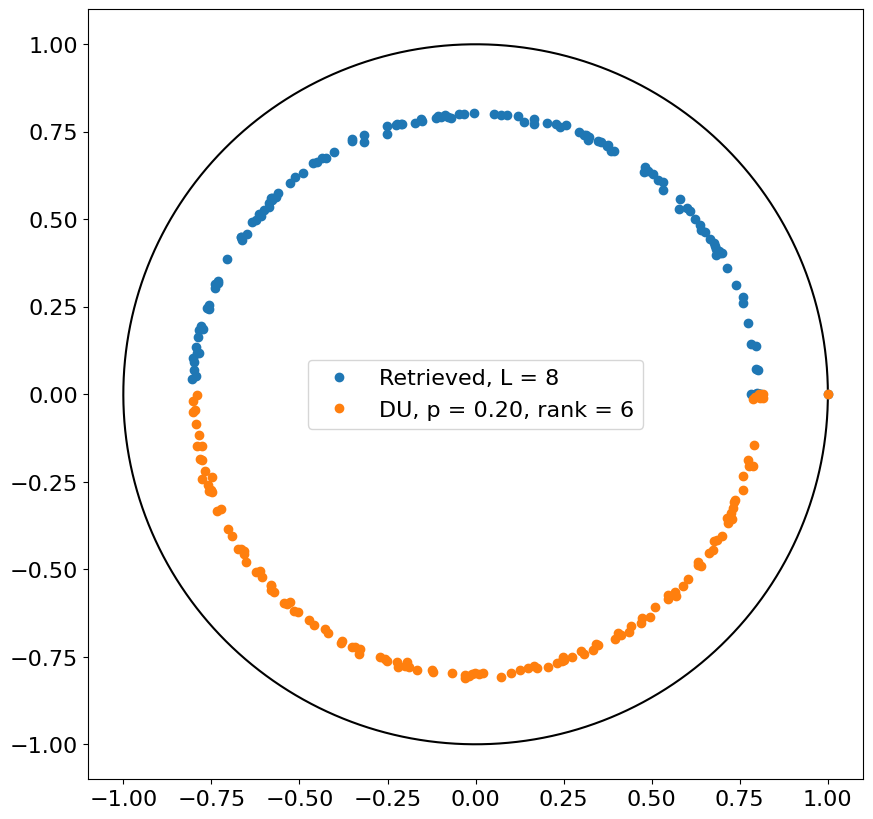

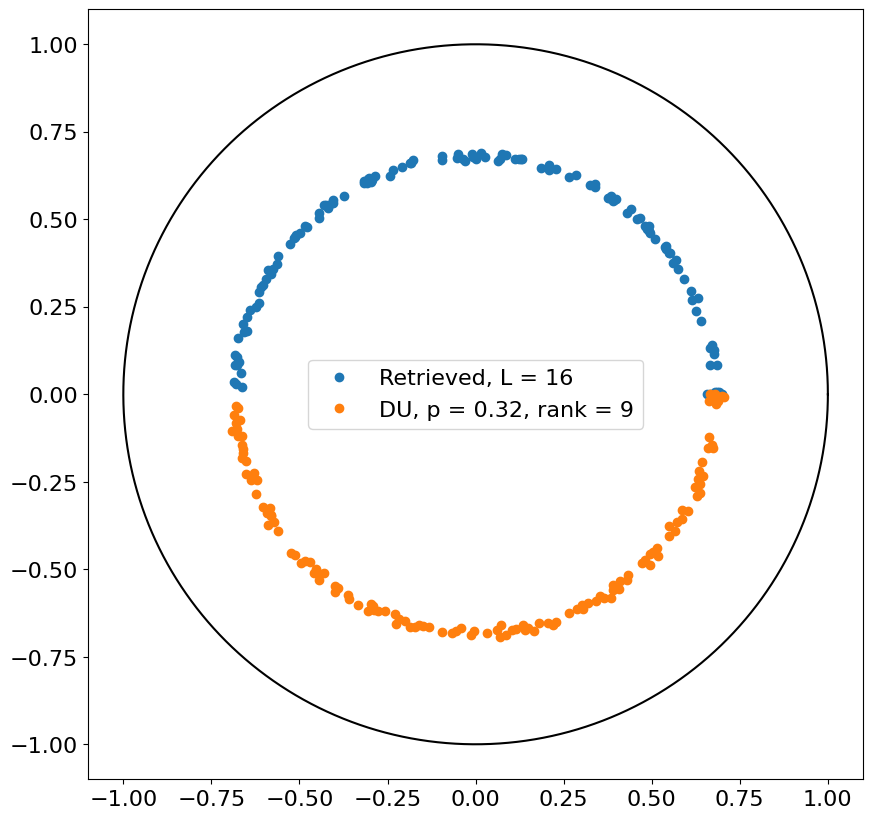

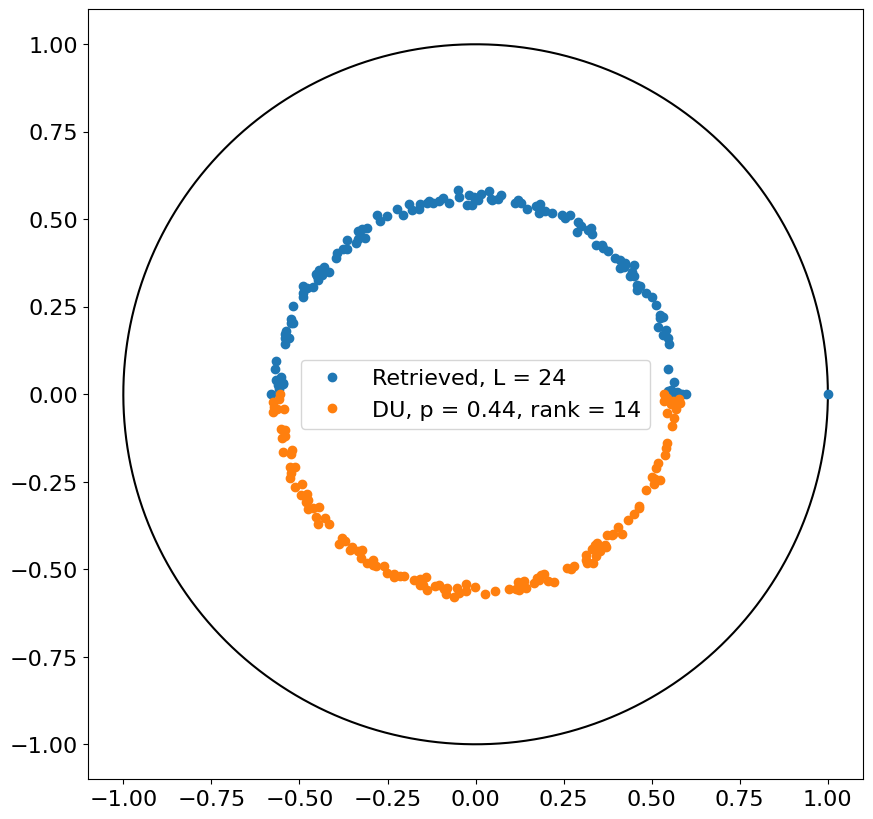

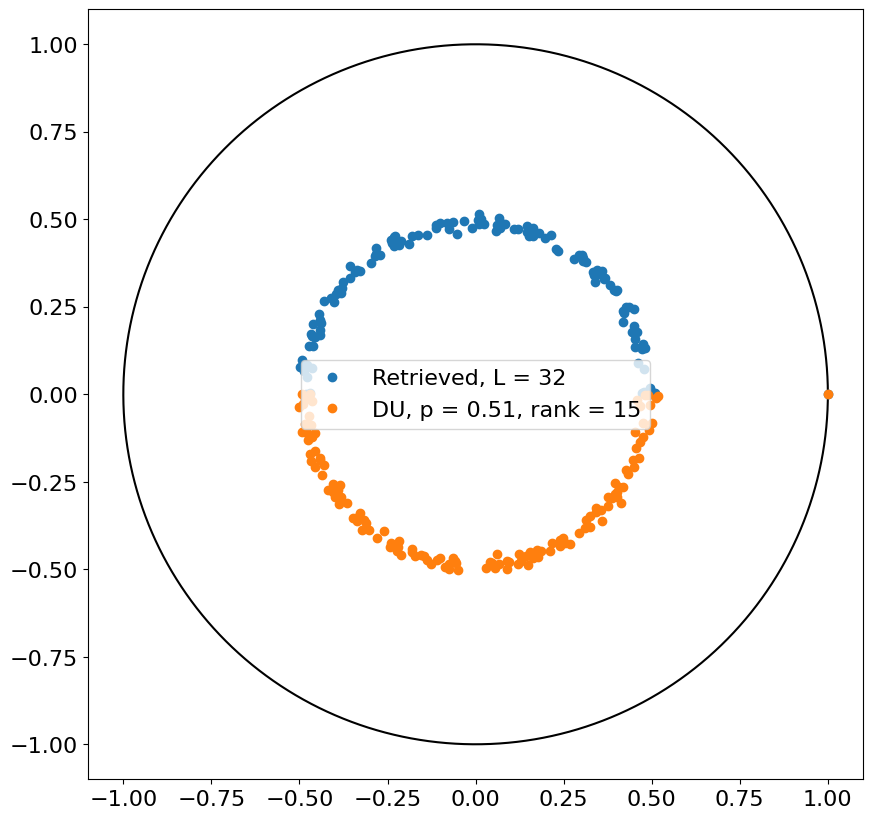

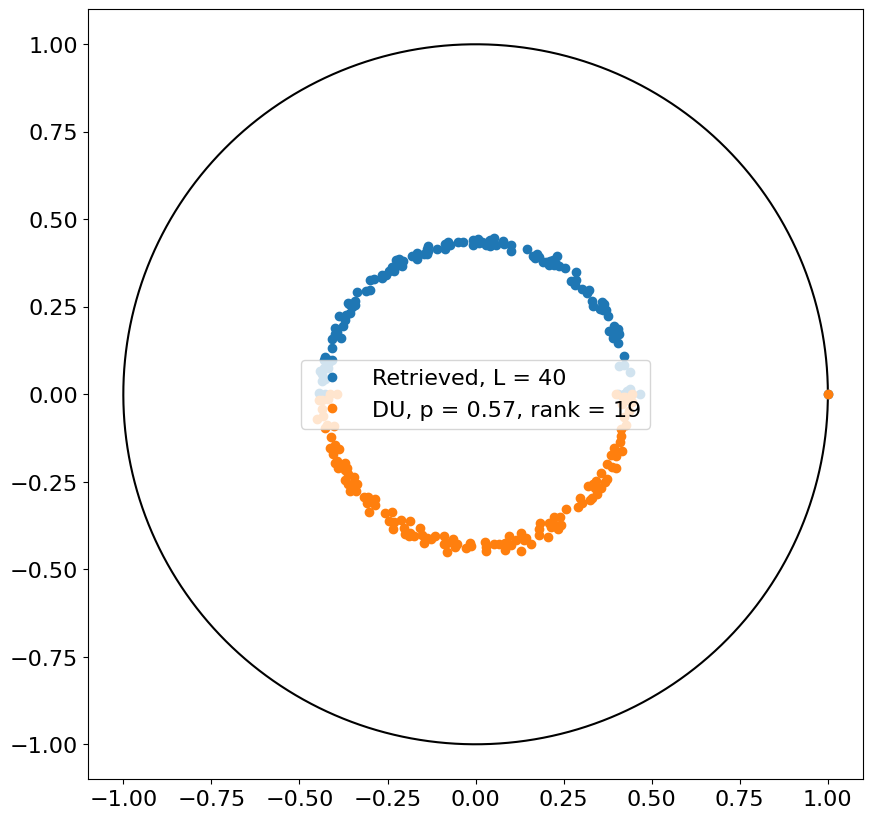

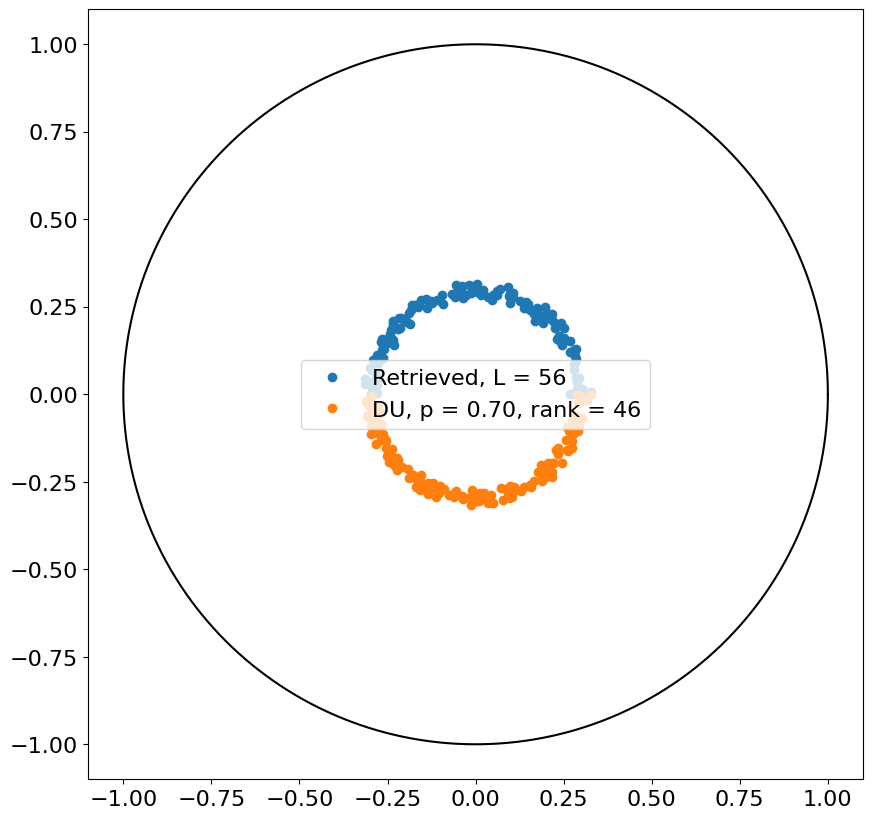

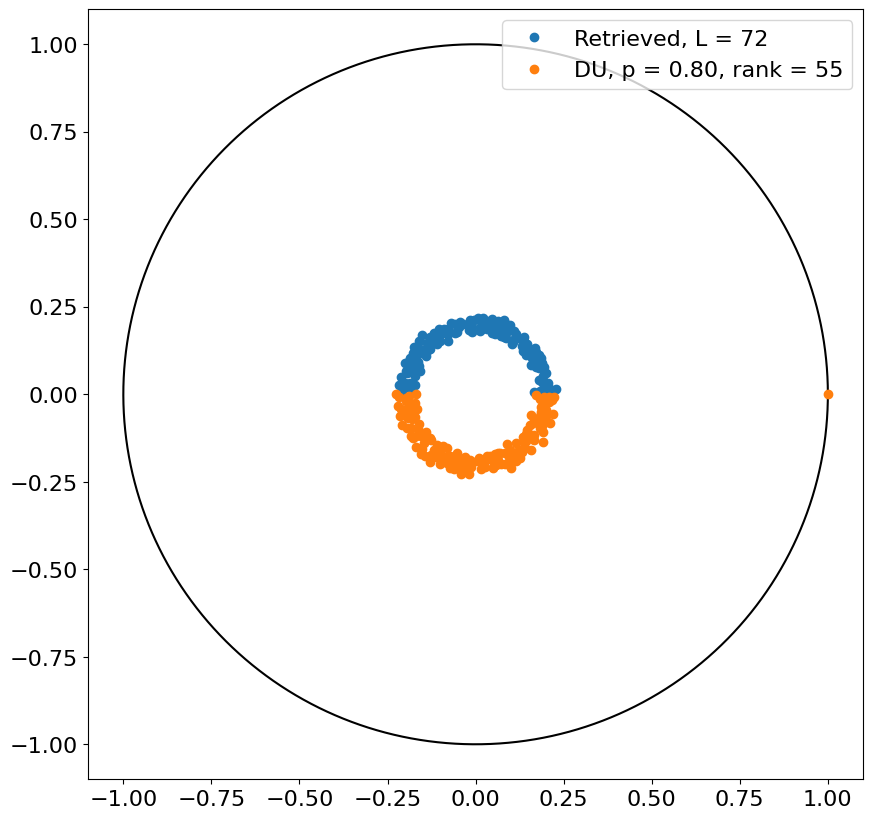

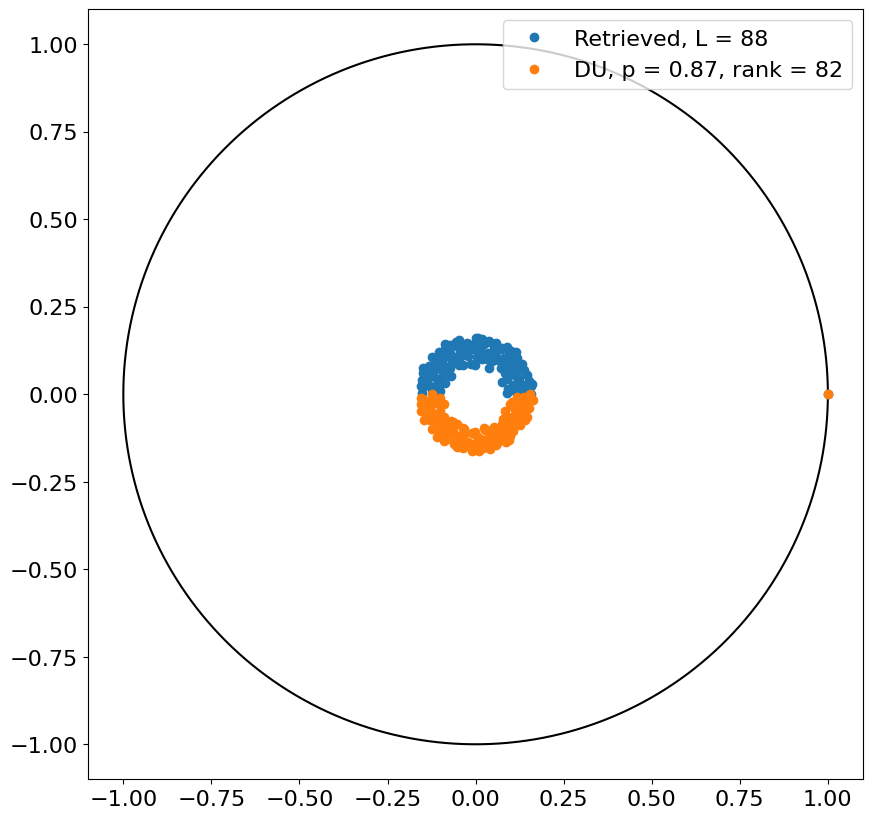

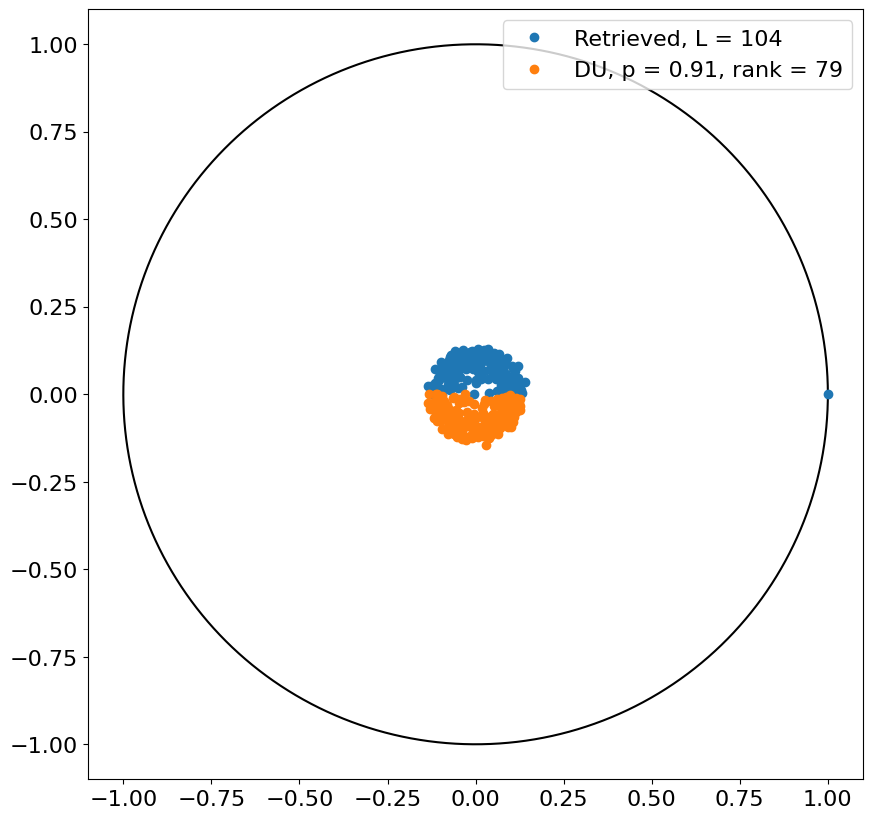

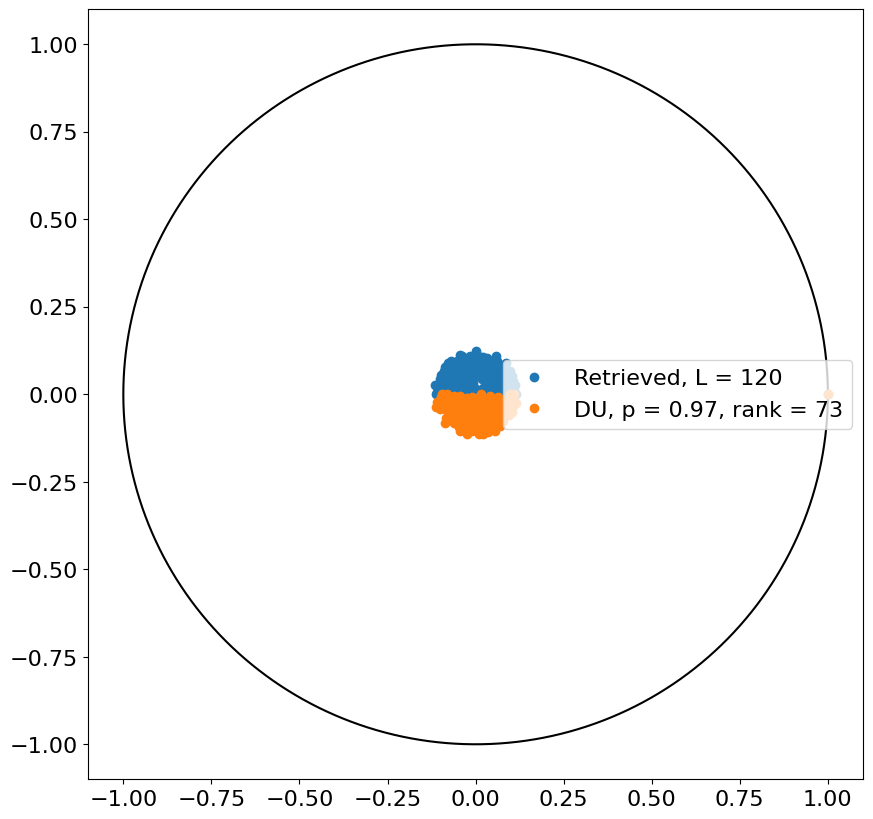

In [5]:
n = 4
d = 2**n

num_layer_list = [8, 16, 24, 32, 40, 56, 72, 88, 104, 120]
#big labels
plt.rc('font', size=16)

p_list = []
rank_list = []

for num_layer in num_layer_list:
    model = pkl.load(open(f"models/L={num_layer}.model", "rb"))
    spectrum = channel_spectrum(model[0].channel)
    spectrum_raw = np.real(spectrum.get_spectrum())
    spectrum_raw = spectrum_raw[spectrum_raw[:,1]>0]

    distance_best, model_best = pkl.load(open("models/" + f"diluted_fitting_KL_4qubit_{num_layer}layer.model", "rb"))
    rank = model_best.channel.rank
    rank_list.append(rank)
    p = 1 - model_best.channel.c
    p_list.append(p)

    spectrum_best = channel_spectrum(model_best.channel)
    spectrum_best_raw = np.real(spectrum_best.get_spectrum())
    spectrum_best_raw = spectrum_best_raw[spectrum_best_raw[:,1]<0]

    
    spectrum.plot_circle()
    plt.plot(spectrum_raw[:,0], spectrum_raw[:,1], "o", label = f"Retrieved, L = {num_layer}")
    plt.plot(spectrum_best_raw[:,0], spectrum_best_raw[:,1], "o", label = f"DU, p = {p:.2f}, rank = {rank}")
    plt.legend()
    plt.savefig(f"figures/spectrum_{num_layer}.png", bbox_inches='tight')
    plt.show()

## Rank and P

In [8]:
with open("data/" + "diluted_fitting_KL_4qubit_zheijang.txt", "w") as f:
    f.write("layers, rank, p\n")
    for i in range(len(num_layer_list)):
        f.write("{}, {}, {}\n".format(num_layer_list[i], rank_list[i], p_list[i]))


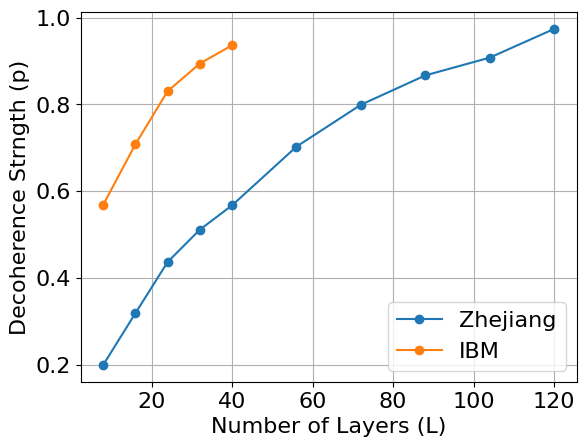

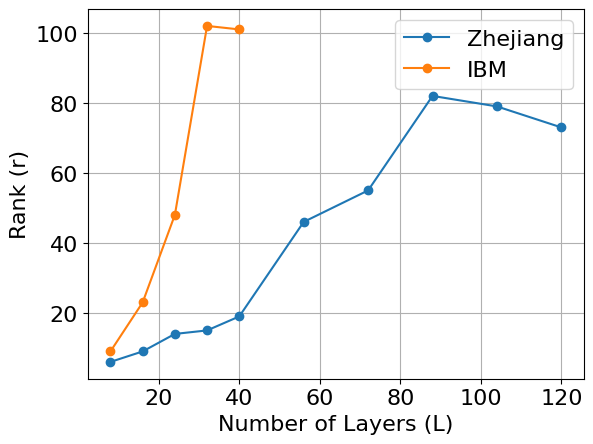

In [6]:
# load "data/diluted_fitting_KL_4qubit_ibm.txt", with layers, p, rank
#ignore the first line
#separated by comma

data = np.loadtxt("data/diluted_fitting_KL_4qubit.txt", delimiter=",", skiprows=1)
num_layer_ibm_list = data[:,0]
rank_ibm_list = data[:,1]
p_ibm_list = data[:,2]



plt.plot(num_layer_list, p_list, "-o", label="Zhejiang")
plt.plot(num_layer_ibm_list, p_ibm_list, "-o", label="IBM")
plt.xlabel("Number of Layers (L)")
plt.ylabel("Decoherence Strngth (p)")
plt.grid()
plt.legend()
plt.savefig("figures/p_vs_L.png")
plt.show()


plt.plot(num_layer_list, rank_list, "-o", label="Zhejiang")
plt.plot(num_layer_ibm_list, rank_ibm_list, "-o", label="IBM")
plt.xlabel("Number of Layers (L)")
plt.ylabel("Rank (r)")
plt.grid()
plt.legend()
plt.savefig("figures/rank_vs_L.png")
plt.show()

